In [1]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [10]:
coco_dataset_path = "/home/kafkaon1/Dev/data/COCO_0503/train_imgs"
coco = COCO('/home/kafkaon1/Dev/data/COCO_0503/annotations_train.json')

ann_ids = coco.getAnnIds(iscrowd=False)
anns = coco.loadAnns(ann_ids)
anns = [ann for ann in anns if len(ann['segmentation']) > 0]


loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


BBox[0] (xyxy): [713.0, 168.0, 1081.0, 323.0]
/home/kafkaon1/Dev/data/COCO_0503/train_imgs/20230630_164906.jpg
(1, 194, 2)


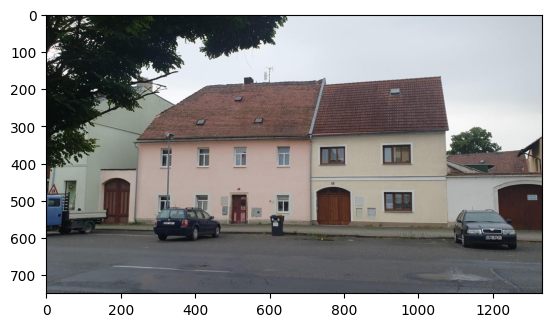

In [103]:

for i, ann in enumerate(anns[100:]):
    image_id = ann["image_id"]
    segs = ann["segmentation"]
    bbox = np.array(ann["bbox"])
    bbox[2:4] = bbox[0:2] + bbox[2:4]
    print("BBox[{}] (xyxy):".format(i), bbox.tolist())
    
    image_info = coco.loadImgs(image_id)
    image_path = image_info[0]["file_name"]
    # [0] is required, always return a list
    image_path = os.path.join(coco_dataset_path, image_path)
    print(image_path)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segs = [np.array(seg, np.int32).reshape((1, -1, 2))
            for seg in segs]
    print(segs[0].shape)
#     for seg in segs: cv2.drawContours(image, seg, -1, (0,255,0), 2)
    # third aug -1 means draw all contours in 3-D array, Or
    # for seg in segs: cv2.fillPoly(image, segm, (0,255,0))
    # cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), 
    #               (int(bbox[2]), int(bbox[3])), (0,0,255), 2)
    plt.imshow(image)

    break

In [13]:
image.shape

(749, 1333, 3)

In [12]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

# load images test_r.png and test_t.png and display them
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid

import torch
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
import models

register_all_modules()

models_mask = {
    'point_rend': ('/home/kafkaon1/Dev/mmdetection/configs/point_rend/point-rend_r101-caffe_fpn_ms-3x_roofs.py', '/home/kafkaon1/Dev/out/pointRendOut1012/epoch_20.pth')
}

model_name = 'point_rend'
model = init_detector(*models_mask[model_name], device='cuda:1') 

ckpt = torch.load('/home/kafkaon1/Dev/out/train/SolAR_KPdet/0325_174823/best_ckpt_ep89.pth', map_location='cuda:0')
model_ref = models.MaxVitUnet(logits=False)
model_ref.load_state_dict(ckpt['state_dict'])

Loads checkpoint by local backend from path: /home/kafkaon1/Dev/out/pointRendOut1012/epoch_20.pth


<All keys matched successfully>

In [13]:
image = cv2.imread('/home/kafkaon1/Dev/FVAPP/demos/sch1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [14]:
min_area_threshold=4000
arc_length_coeff=0.005
PATCH_SIZE = 256


In [15]:
res = inference_detector(model, image)
            
estimate_points = []
# go through all masks -> check if are roofs -> polygonize -> collect are polygon points
for i, mask in enumerate(res.pred_instances['masks'][0:]):
    if res.pred_instances['scores'][i] < 0.5:
        continue
    
    if res.pred_instances['labels'][i] != 0:
        continue
    
    if mask.sum() < 1:
        continue
    
    polygon_vertices = None
    mask = mask.cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        epsilon = arc_length_coeff * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        area = cv2.contourArea(approx)

        if len(approx) >= 3 and area > min_area_threshold:
            polygon_vertices = approx.reshape(-1, 2).astype(np.float32)
            estimate_points += [*polygon_vertices]
            
    break

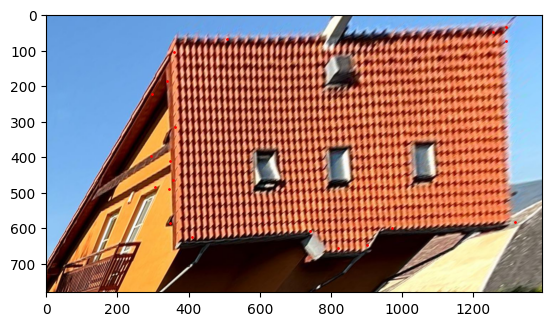

In [16]:
plt.imshow(image)
estimate_points = np.array(estimate_points)
plt.scatter(estimate_points[:, 0], estimate_points[:, 1], c='r', s=1)

In [62]:
import torch.nn as nn
import torch
import numpy as np


PATCH_SIZE = 256

class CornerRefiner(nn.Module):
    def __init__(self, ckpt_path, device='cuda:0', noise_thr=0.08, conf_thr=0.18, dst_thr=30):
        '''
            ckpt_path : path to the checkpoint of the model
            device : device to run the model on
            noise_thr : threshold under which everything in keypoint heatmap is regarder as noise
            conf_thr : threshold above which every heatmap local maximum is regarded as new keypoint
            dst_thr : threshold for the distance between the refined keypoint and the original point
        '''
        super(CornerRefiner, self).__init__()
        self.model = models.MaxVitUnet(logits=False)
        ckpt = torch.load(ckpt_path, map_location=device)
        self.model.load_state_dict(ckpt['state_dict'])
        self.noise_thr = noise_thr
        self.conf_thr = conf_thr
        self.dst_thr = dst_thr
        
    
    def forward(self, img, roof_polygon):
        '''
            img : np.array of shape (H, W, 3)
            roof_polygon : polygonized roof mask to be refined
            
            returns : refined polygon
        '''
        thr = 0.1
        out_polygon = []
        for pt in roof_polygon:
            
            patch, offset = get_patch(img, *pt) # get patch around the point and the offset of the point in the patch
            patch = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float()/255
            out = self.model(patch)
            
            sc, indi = get_keypoint_coords(out, self.noise_thr)
            ind = indi[0] # as there is no batch approach imlpemented yet
            print(offset, ind, sc)
            plt.imshow(patch[0].permute(1,2,0).cpu().detach().numpy())
            plt.imshow(out[0][0].cpu().detach().numpy(), alpha=0.3)
            plt.scatter(ind[:, 1], ind[:, 0], c='r', s=1)
            plt.show()
            if len(ind) == 0:
                continue
            dists = torch.pow(ind - np.array(offset), 2).sum(axis=1)
            print(dists)         
            # closest keypoint
            dst = dists.min().item()
            dst_id = dists.argmin().item()
            
            score = sc[0][dst_id]
            if score > thr and dst < self.dst_thr**2:
                indc = ind[torch.argmin(dists)]
                out_polygon.append(indc)
            
        return out_polygon
            
        
def get_patch(img, x, y):
    # create 256x256 patch with the point in the middle from img with prevence against overflowing
    
    x_ = x if x >= PATCH_SIZE//2 else PATCH_SIZE//2
    y_ = y if y >= PATCH_SIZE//2 else PATCH_SIZE//2
    x_ = x_ if x_ <= img.shape[1] - PATCH_SIZE//2 else img.shape[1] - PATCH_SIZE//2
    y_ = y_ if y_ <= img.shape[0] - PATCH_SIZE//2 else img.shape[0] - PATCH_SIZE//2
    x_ = int(x_)
    y_ = int(y_)
    
    # offset of the point in the patch
    xo = x - x_ + PATCH_SIZE//2
    yo = y - y_ + PATCH_SIZE//2
    return img[y_-PATCH_SIZE//2:y_+PATCH_SIZE//2, x_-PATCH_SIZE//2:x_+PATCH_SIZE//2], torch.tensor([yo, xo])


def get_keypoint_coords(heatmap, noise_thr):
    '''
        Function for getting the keypoint coordinates from the heatmap,
        it is basically getting local maxima of the heatmap using maxpooling
        TODO - complete batch-based approach
    '''
    min_keypoint_pixel_distance = 5
    
    batch_size, n_channels, _, width = heatmap.shape
    heatmap[heatmap < noise_thr] = 0 # filter noise
    kernel = min_keypoint_pixel_distance * 2 + 1
    pad = min_keypoint_pixel_distance
    # exclude border keypoints by padding with highest possible value
    # bc the borders are more susceptible to noise and could result in false positives
    padded_heatmap = torch.nn.functional.pad(heatmap, (pad, pad, pad, pad), mode="constant", value=0)
    max_pooled_heatmap = torch.nn.functional.max_pool2d(padded_heatmap, kernel, stride=1, padding=0)
    # if the value equals the original value, it is the local maximum
    local_maxima = torch.bitwise_and(max_pooled_heatmap == heatmap, heatmap > 0)
    # all values to zero that are not local maxima
    heatmap = heatmap * local_maxima
    num_pts = torch.sum(local_maxima)
    if num_pts == 0: # no local maxima found - topk would complain
        return torch.zeros(batch_size, 0, 1), torch.zeros(batch_size, 0, 2)
    
    # extract top-k from heatmap (may include non-local maxima if there are less peaks than max_keypoints)
    scores, indices = torch.topk(heatmap.view(batch_size, -1), num_pts, sorted=True)
    indices = torch.stack([torch.div(indices, width, rounding_mode="floor"), indices % width], dim=-1)
    return scores, indices



In [63]:
ref = CornerRefiner('/home/kafkaon1/Dev/out/train/SolAR_KPdet/0325_174823/best_ckpt_ep62.pth')


tensor([ 35., 153.], dtype=torch.float64) tensor([[ 11, 173]]) tensor([[0.1816]], grad_fn=<TopkBackward0>)


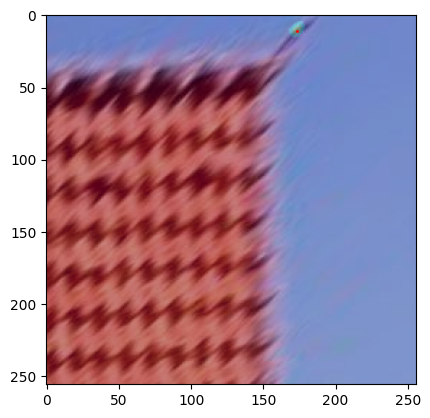

tensor([976.], dtype=torch.float64)
tensor([ 69., 128.], dtype=torch.float64) tensor([], size=(0, 2)) tensor([], size=(1, 0, 1))


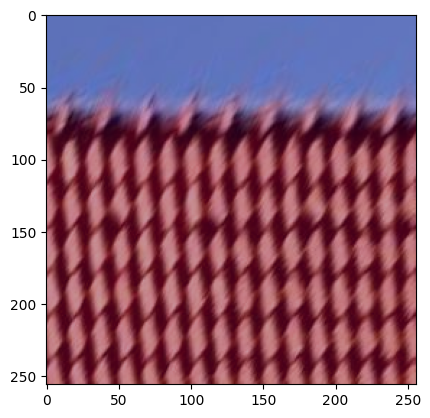

tensor([105., 128.], dtype=torch.float64) tensor([[ 72, 137],
        [ 74, 149]]) tensor([[0.2513, 0.0826]], grad_fn=<TopkBackward0>)


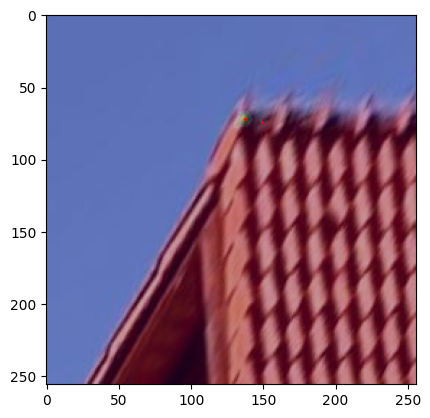

tensor([1170., 1402.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[247, 169],
        [ 83, 145],
        [105, 167]]) tensor([[0.3609, 0.1939, 0.0951]], grad_fn=<TopkBackward0>)


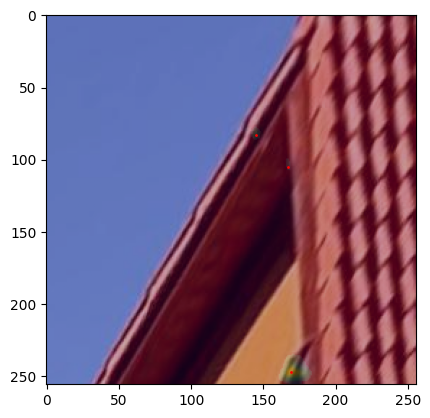

tensor([15842.,  2314.,  2050.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[ 14, 152],
        [ 20, 163]]) tensor([[0.2653, 0.1439]], grad_fn=<TopkBackward0>)


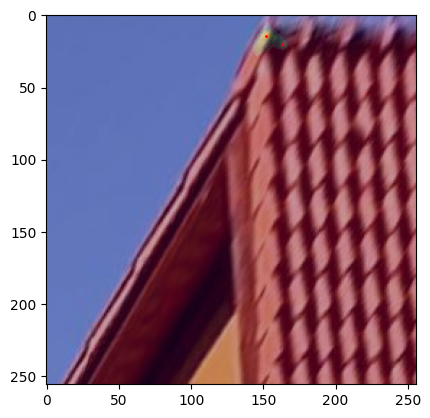

tensor([13572., 12889.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[150, 107],
        [235,   5],
        [  1,  82]]) tensor([[0.3313, 0.0963, 0.0930]], grad_fn=<TopkBackward0>)


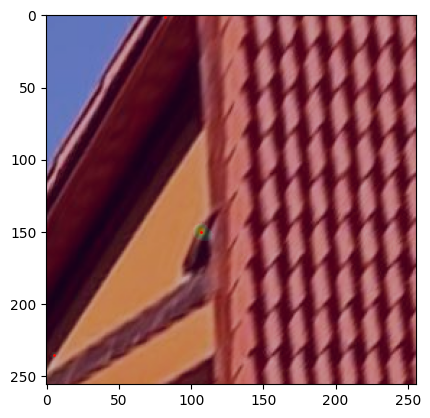

tensor([  925., 26578., 18245.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[113, 178],
        [208,  34]]) tensor([[0.4623, 0.1440]], grad_fn=<TopkBackward0>)


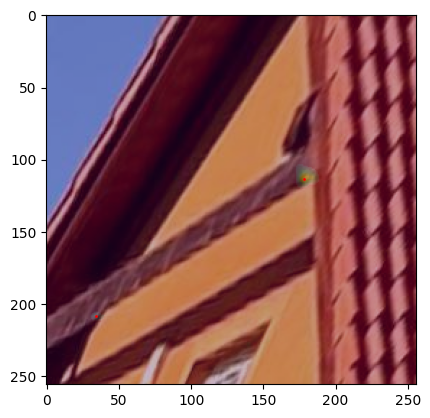

tensor([ 2725., 15236.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[168,   5],
        [102, 122],
        [138,  30]]) tensor([[0.4777, 0.1392, 0.1174]], grad_fn=<TopkBackward0>)


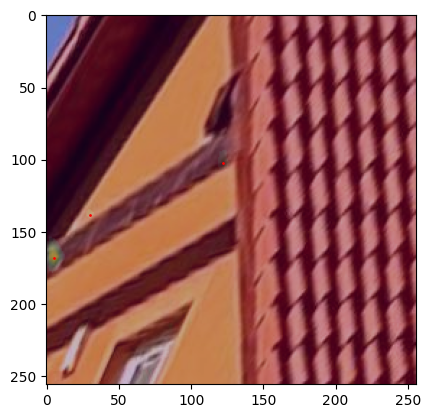

tensor([16729.,   712.,  9704.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[128,  19],
        [122,   2],
        [ 11, 160]]) tensor([[0.1359, 0.0829, 0.0802]], grad_fn=<TopkBackward0>)


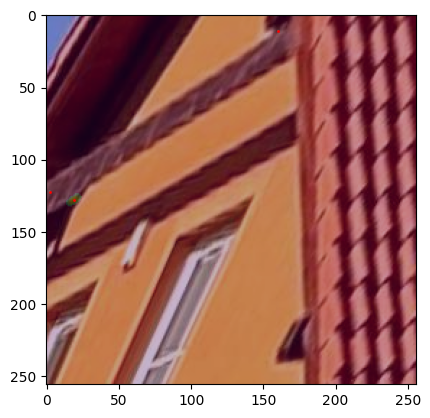

tensor([11881., 15912., 14713.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[206, 143]]) tensor([[0.2168]], grad_fn=<TopkBackward0>)


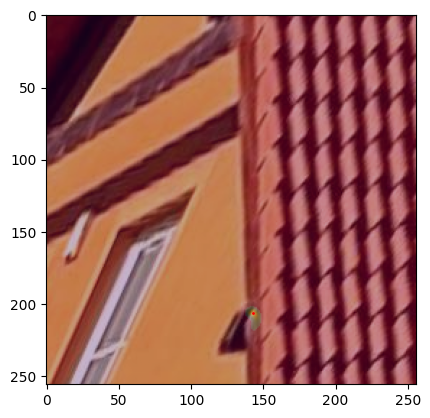

tensor([6309.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[244, 130],
        [ 39, 110]]) tensor([[0.2028, 0.1913]], grad_fn=<TopkBackward0>)


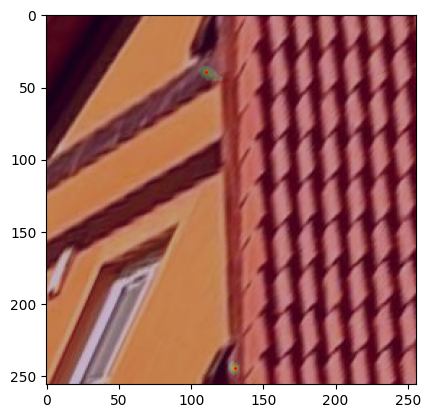

tensor([13460.,  8245.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[181, 156]]) tensor([[0.2812]], grad_fn=<TopkBackward0>)


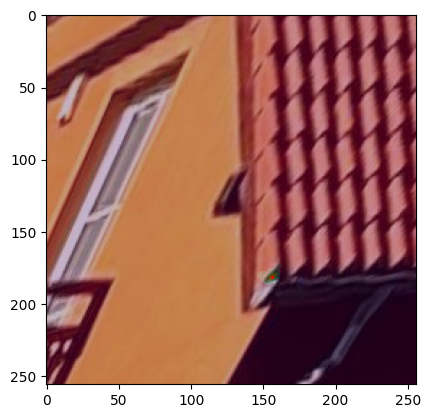

tensor([3593.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[135,  97],
        [ 79,  81],
        [253,  46]]) tensor([[0.5041, 0.1509, 0.1162]], grad_fn=<TopkBackward0>)


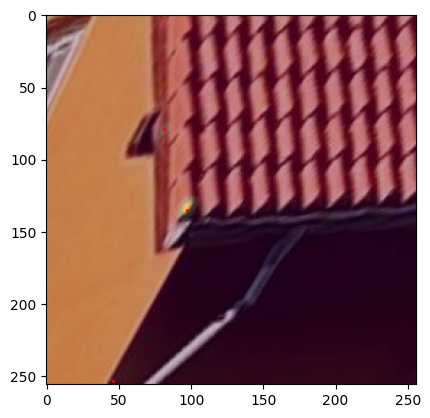

tensor([ 1010.,  4610., 22349.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[188, 171],
        [126, 123]]) tensor([[0.4144, 0.2533]], grad_fn=<TopkBackward0>)


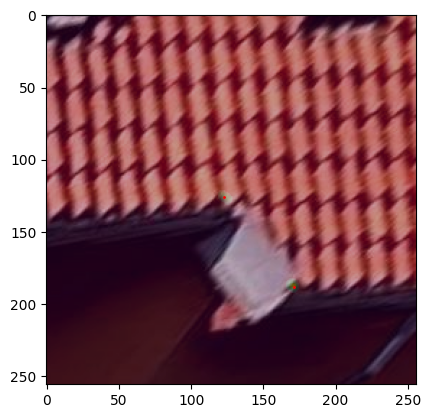

tensor([5449.,   29.], dtype=torch.float64)
tensor([130., 128.], dtype=torch.float64) tensor([[140,  92],
        [132, 218]]) tensor([[0.5506, 0.2371]], grad_fn=<TopkBackward0>)


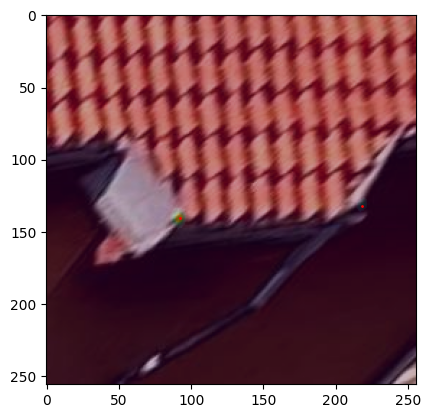

tensor([1396., 8104.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[136, 136],
        [ 80, 143],
        [148,   7]]) tensor([[0.5176, 0.2988, 0.1726]], grad_fn=<TopkBackward0>)


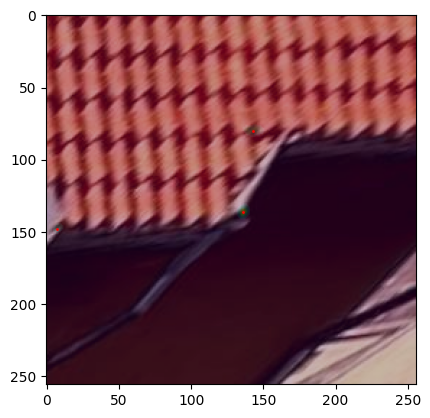

tensor([  128.,  2529., 15041.], dtype=torch.float64)
tensor([128., 128.], dtype=torch.float64) tensor([[128,  96],
        [131,  77]]) tensor([[0.2117, 0.1351]], grad_fn=<TopkBackward0>)


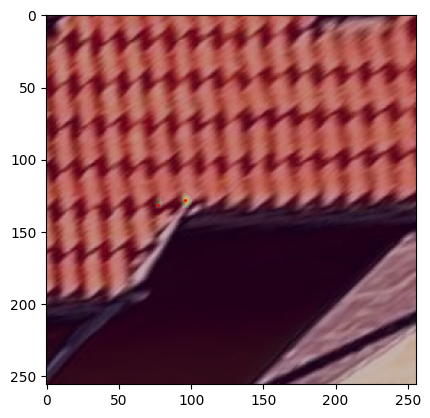

tensor([1024., 2610.], dtype=torch.float64)
tensor([128., 179.], dtype=torch.float64) tensor([[125, 152],
        [138, 197]]) tensor([[0.5465, 0.4138]], grad_fn=<TopkBackward0>)


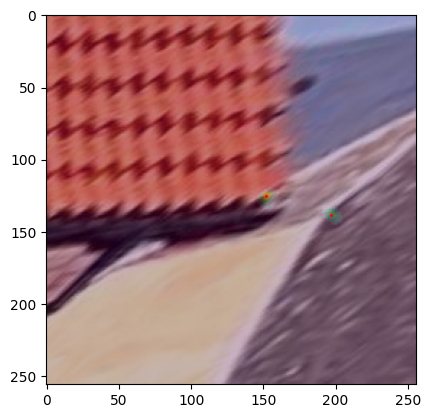

tensor([738., 424.], dtype=torch.float64)
tensor([ 72., 154.], dtype=torch.float64) tensor([[ 11, 173]]) tensor([[0.1816]], grad_fn=<TopkBackward0>)


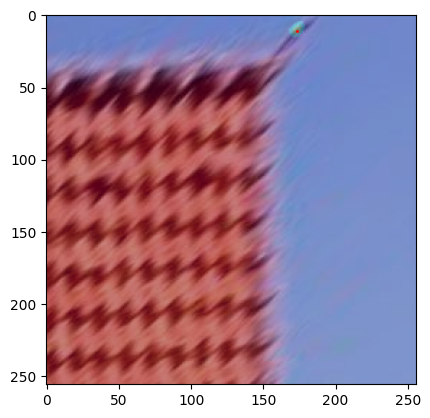

tensor([4082.], dtype=torch.float64)
tensor([ 49., 128.], dtype=torch.float64) tensor([[  9, 183]]) tensor([[0.0892]], grad_fn=<TopkBackward0>)


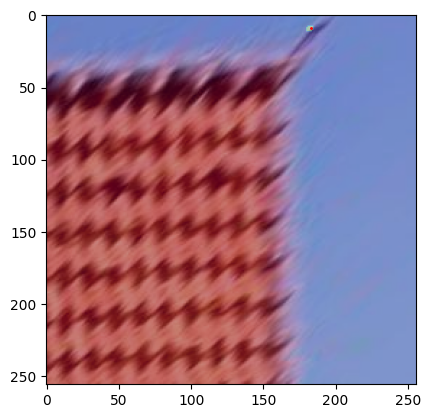

tensor([4625.], dtype=torch.float64)


[tensor([102, 122]),
 tensor([126, 123]),
 tensor([136, 136]),
 tensor([138, 197])]

In [64]:
ref(image, estimate_points)

In [9]:
import torch
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
import models
import matplotlib.pyplot as plt
from parse_config import ConfigParser
import argparse
import dataset as data_module   
from utils import read_json, write_json, setup_logging
import torch

config = read_json('/home/kafkaon1/Dev/FVAPP/configs/config_kp.json')

config = ConfigParser(config, None)

train_loader = config.init_obj('train_data_loader', data_module)
valid_loader = config.init_obj('val_data_loader', data_module)


In [5]:
ckpt = torch.load('/home/kafkaon1/Dev/out/train/SolAR_KPdet/0326_052415/best_ckpt_ep150.pth', map_location='cuda:0')
model_ref = models.MaxVitUnet(logits=False)
model_ref.load_state_dict(ckpt['state_dict'])
model_ref.eval()

/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/torch/overrides.py:118: 

MaxVitUnet(
  (encoder): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MaxxVitBlock(
            (conv): MbConvBlock(
              (shortcut): Downsample2d(
                (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
                (expand): Identity()
              )
              (pre_norm): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
              (down): Identity()
              (conv1_1x1): Conv2d

In [6]:
ID = 12

In [11]:
tst = valid_loader.dataset[ID][0].unsqueeze(0)
out = model_ref(tst)
out.min()

tensor(4.4562e-05, grad_fn=<MinBackward1>)

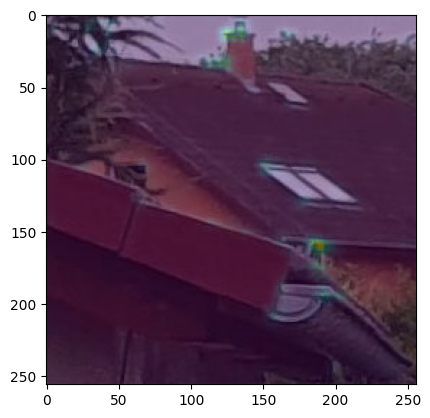

In [10]:
plt.imshow(valid_loader.dataset[ID][0].permute(1,2,0).detach().cpu().numpy())
#plt.imshow(valid_loader.dataset[ID][1][0].detach().cpu().numpy(), alpha = 0.4)
plt.imshow(out[0, 0].detach().cpu().numpy(), alpha = 0.4)